In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GRU,Conv1D, MaxPooling1D,SpatialDropout1D
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.layers import CuDNNGRU
from keras.layers.merge import concatenate, add
from keras.layers import Input,Reshape,Conv2D,MaxPool2D, concatenate

from keras.utils import multi_gpu_model
from keras.models import model_from_json,Model
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_a_v16.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (14247, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4
                              #jieba_dict_path5
                             ],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_2RNN/jieba/dict_taiwan.txt ...
Dumping model to file cache /tmp/jieba.u5f4d4d2a4ebf6cacbf248ccc4ee696aa.cache
Loading model cost 0.727 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入顯示訊息無效的帳號或不存在帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假要補登先前的加班但開啟camp後出勤表單顯示的內容像測試的沒有的時間也沒辦法使用已...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核bpm有問題都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用camp進行表單簽核動作,4
4,無法打開報單資料,CAMP,CAMP,CAMP,CAMP,資訊系統,無法打開報單資料,4


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list
df_all.groupby(["category"]).size()

category
Outlook與郵件    4123
SAP           1736
其他            1210
網路            5761
資訊系統          1417
dtype: int64

In [9]:
def cut_to_word(s):
    blCondition=True
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    combieNO=''
    beforeWord=''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        conditionWord = str(combieNO) + str(w)
        
        if combieNO != '' :# and len(conditionWord) == 4:and len(w)>1
            combie = combie + w +','
            combie = combie+combieNO+w
            #print(combieNO+w)
        else:        
            #87.2%=>
            if w in ['修改','顯示','申請單','問題','系統','作業','權限','訊息'] and beforeWord!='' and blCondition :#and len(w)>1
                combie = combie +w+','
                combie = combie+beforeWord+w
            else:
                combie = combie + w
                 
        if i < len(w_list) - 1 and combie !='':
            combie = combie + ','
            
        blAdd = True
        if w in ['無法','不能','電腦','安裝','密碼','下載','上傳','開啟','無線'] and blCondition:#,'安裝','編輯','刪除','新增','作業','忘記','系統','發生','作業','下載','上傳','開啟','安裝']#,'加班','請假','預約','作業'
            combieNO = w
        else:
            combieNO = ''
        beforeWord=w
    return combie    

def cut_to_word2(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        
        #if len(w)>1:
        combie = combie + w
                 
        if i < len(w_list) - 1:# and len(w)>1:#
            combie = combie + ','
            
    return combie  

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word2(s.strip()))


In [10]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,帳號密碼無法使用，申請單號: APP0079554 #16060,網管,網路,訪客網路,訪客輸入帳號無法成功,網路,帳號密碼申請單號 app54,3,"帳號密碼,申請單,號,app54"
1,客人無法寄信到我的信箱 請幫忙找原因 #16912,網管,Outlook與郵件,郵件傳送追蹤,沒有收到某封郵件,Outlook與郵件,客人無法寄信到我的信箱 找原因,0,"客人,寄信,到,信箱,找,原因"
2,pst檔案複製到本機下載mail時斷線 結果信件遺失,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,pst檔案複製到本機下載mail時斷線 信件遺失,0,"pst,檔案,複製到,本機,下載,mail,時,斷線,信件,遺失"
3,可連上外部網路，但無法連上內部網路的Server (#16568),網管,網路,電腦網路不通,網路不通 (QRDC),網路,可連上外部網路但無法連上內部網路的server,3,"可連上,外部,網路,內部網路,server"
4,硬碟損壞自行更換救資料，outlook變為試用版,網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,硬碟損壞自行更換救資料outlook變為試用版,0,"硬碟,損壞,自行,更換,救,資料,outlook,變為,試用版"


In [11]:
df_all[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,送出申請單發生錯誤訊息 試了很多次還是一樣 #13012,BPM平台系統,事務類相關服務,物品申請單,相關操作詢問,資訊系統,送出申請單發生錯誤訊息,4,"送,申請單,發生,錯誤,訊息"
3041,"使用者反應 Outlook 無法開啟, 請協處!",網管,Outlook與郵件,Outlook,Outlook點不開,Outlook與郵件,outlook 請協處,0,"outlook,請,協處"
3042,SAP帳號鎖住,SAP-168(QCI),Basis,帳號,帳號無法使用,SAP,sap帳號鎖住,1,"sap,帳號,鎖住"
3043,有兩個問題: 1. 如何設定關閉資料夾窗格，已經設定關閉資料夾了，但切換到其他資料夾後設定...,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,有兩個 1. 設定關閉資料夾窗格已經設定關閉資料夾了但切換到資料夾後設定又需要重新有沒有方...,0,"兩個,1,設定,關閉,資料夾,窗格,已經,設定,關閉,資料夾,切換到,資料夾,後,設定,需要..."
3044,預報加班系統異常.主管簽核完成後仍然顯示預報中.,CAMP,CAMP,CAMP,CAMP,資訊系統,預報加班系統異常.簽核完成後顯示預報中,4,"預報,加班,系統,異常,簽核,完成,後,顯示,預報,中"
3045,"網路不通, 網路孔號:PA9009, 請協助處理",網管,網路,電腦網路不通,網路不通 (QRDC),網路,網路不通 網路孔號pa,3,"網路,不通,網路,孔號,pa"
3046,網路孔編號:PH20A164 分機:15680,網管,網路,電腦網路不通,網路不通 (TH20),網路,網路孔編號ph20a164,3,"網路,孔,編號,ph20a164"
3047,郵箱爆了，無法收信發信 EXT:17167,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,郵箱爆了無法收信發信,0,"郵箱,爆,收信,發信"
3048,PC想重新安裝win7 想要拿光碟重灌 #17767,網管,作業系統與印表機,其它,其他事項,其他,pc想重新安裝win7 拿光碟重灌,2,"pc,重新安裝,win7,光碟,重灌"
3049,"當網路線重新拔插後, 就會停留在驗證中, 重開機後可恢復正常, 針對這種情況, 是否有什麼方...",網管,網路,電腦網路不通,網路不斷出現驗證訊息,網路,當網路線重新拔插後 就會停留在驗證中 重開機後可恢復正常 針對這種情況 是否有方式可以手動調...,3,"網路線,重新,拔,插,後,停留,驗證,中,重,開機,後,恢復正常,針對,這種,情況,是否,方..."


In [12]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [14]:
X_train.head()

4483                                           268,bom,問題
2179                    新增,退,料單,系統,顯示,無此,機種,名稱,tcodezmi1h
4810                          outlook,點,信件,當機,web,mail,很慢
2209                                        outlook,顯示,啟動
5179    信件,郵件,太大當,刪除,郵件,時,outlook,卻又,顯示,刪除,導致,outlook,...
Name: cut_words, dtype: object

In [15]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0.]
num_classes = 5


In [16]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)
    
    #print(char_index)
    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)
char_index = token_intent.word_index

In [17]:
x_train

array([[   0,    0,    0, ...,  308,  272,    5],
       [   0,    0,    0, ..., 1524,  173, 4893],
       [   0,    0,    0, ...,  167,   12,  176],
       ...,
       [   0,    0,    0, ...,  205,  339,  324],
       [   0,    0,    0, ...,   10,    3,   43],
       [   0,    0,    0, ...,   25,   13,  348]], dtype=int32)

In [18]:
# set parameters:
max_features = 5001
maxlen = 100
batch_size = 20
embedding_dims = 50
filters = 100
kernel_size = 10
hidden_dims = 250
epochs = 10
train_ratio = 0.9

In [19]:
from keras.layers import Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
 
 
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
 
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
 
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
 
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
 
        a = K.exp(ait)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [20]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [21]:
#84.6%,83%,84%,83.9%,85%,84%,85.3%,86.2%
from keras.layers import core,BatchNormalization
from keras.layers import CuDNNLSTM
def BidCuDNNLSTM2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(CuDNNLSTM(32)))#, return_sequences=True
#    model.add(Attention(30))
#     model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [22]:
#83.8%,83.4%,83.9%,84.8%,84.3%,87.7%
def BidCuDNNLSTM2_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))#
    model.add(AttentionWithContext())
#     model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [23]:
#84.7%,88.29%
def BidLSTM_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(LSTM(32,implementation=2, return_sequences=True))
    model.add(AttentionWithContext())
    #model.add(Flatten())
    #model.add(Dense(64,activation='tanh'))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [24]:
#74.8%#83%,82%,84%,83%,81%
def BidLSTM(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
#     model.add(GRU(128))
    model.add(Bidirectional(LSTM(32)))
#     model.add(Bidirectional(LSTM(128,implementation=2)))

    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [25]:
#79%,83%
def BidCuDNNGRU(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(CuDNNGRU(64)))#
    #model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    #model.add(Attention(29))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [26]:
#70.2%,83.7%,83.18%,83.8%
def BidCuDNNGRU_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(CuDNNGRU(64,return_sequences=True))#
    model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    model.add(AttentionWithContext())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [27]:
def GRU2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(CuDNNGRU(64)))#return_sequences=True
    #model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    #model.add(Attention(29))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [28]:
#84%,81.9%
def GRU2_Attention(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(GRU(64,return_sequences=True))#
    model.add(Conv1D(32, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform"))
    model.add(AttentionWithContext())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [29]:
#84.09%,85.5%,84.6%,86%,84.9%,87.8%,86.8%
#https://github.com/jdp527/DL_Text_Classification/blob/master/models/gpu_model.py
#https://aclweb.org/anthology/C16-1329
def blstm_2dcnn(num_classes, max_features, maxlen,embed_size,
               embedding_dropout = .5,
               blstm_units = 1024,
               blstm_dropout = .2,
               cnn_filters = 256,
               cnn_kernel_size = (5,5),
               max_pool_size = (5,5),
               dense_dropout = .5,
               l2_reg = .00001,
               gpus = 2):
    
    '''
    Bidirectional LSTM with Two-dimensional Max Pooling
    
    :param maxlen: max length of sequence
    :param max_features: max number of word embeddings
    :param embed_size: dimension of word embeddings
    :param embedding_matrix: embedding matrix created from embed file
    :param embedding_dropout: dropout after embedding layer
    :param blstm_units: number of lstm units for the biderectional lstm
    :param blstm_dropout: dropout after the blstm layer
    :param cnn_filters: number of CNN filters
    :param cnn_kernel_size: kernel size of the convolution
    :param max_pool_size: max pool size
    :param dense_dropout: dropout before dense layer
    :param l2_reg: l2 kernel regularizer parameter
    :gpus: number of gpus
    :returns: Keras parallel model
    '''
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, #weights=[embedding_matrix], 
                  input_length=maxlen)(inp)
    x = Dropout(embedding_dropout)(x)    

    x = Bidirectional(CuDNNLSTM(blstm_units, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(blstm_dropout)(x)
    x = Reshape((maxlen, blstm_units, 1))(x)

    x = Conv2D(cnn_filters, kernel_size=cnn_kernel_size, padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=max_pool_size)(x)

    x = Flatten()(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(num_classes, activation = "softmax",  kernel_regularizer=regularizers.l2(l2_reg))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    #parallel_model = multi_gpu_model(parallel_model, gpus=gpus)
    parallel_model.summary()
    return parallel_model

In [30]:
#85.2%,85.4%,86%,85.5%,87.9%,87.4%,87.3%,87.5%,88%,87.6%,88.1%,88%,88.8%
def bgru_2dcnn(num_classes, max_features, maxlen,embed_size,
               embedding_dropout = .5,
               bgru_units = 1024,
               bgru_dropout = .2,
               cnn_filters = 256,
               cnn_kernel_size = (5,5),
               max_pool_size = (5,5),
               dense_dropout = .5,
               l2_reg = .00001,
               gpus = 2):
    
    '''
    Bidirectional GRU with Two-dimensional Max Pooling
    
    :param maxlen: max length of sequence
    :param max_features: max number of word embeddings
    :param embed_size: dimension of word embeddings
    :param embedding_matrix: embedding matrix created from embed file
    :param embedding_dropout: dropout after embedding layer
    :param bgru_units: number of gru units for the biderectional gru
    :param bgru_dropout: dropout after the bgru layer
    :param cnn_filters: number of cnn filters
    :param cnn_kernel_size: kernel size of the convolution
    :param max_pool_size: max pool size
    :param dense_dropout: dropout before dense layer
    :param l2_reg: l2 kernel regularizer parameter
    :gpus: number of gpus
    :returns: Keras parallel model
    '''
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, #weights=[embedding_matrix], 
                  input_length=maxlen)(inp)
    x = Dropout(embedding_dropout)(x)    

    x = Bidirectional(CuDNNGRU(bgru_units, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(bgru_dropout)(x)
    x = Reshape((maxlen, bgru_units, 1))(x)

    x = Conv2D(cnn_filters, kernel_size=cnn_kernel_size, padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=max_pool_size)(x)

    x = Flatten()(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(num_classes, activation = "softmax",  kernel_regularizer=regularizers.l2(l2_reg))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    #parallel_model = multi_gpu_model(parallel_model, gpus=gpus)
    #parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model

In [31]:
x_train.shape

(11397, 30)

In [32]:
from keras.layers import TimeDistributed
#https://www.kaggle.com/sermakarevich/hierarchical-attention-network
def HAN2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    GPU_IMPL = 2          
    GRU_UNITS = 100   
    REG_PARAM = 1e-13
    l2_reg = regularizers.l2(REG_PARAM)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(GRU(64,return_sequences=True,kernel_regularizer=l2_reg, 
                           implementation=GPU_IMPL)))#
    model.add(AttentionWithContext())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    

def HAN(num_classes, vocab_size, maxlen,embed_size):
    MAX_WORD_LENGTH = 1
    MAX_WORDS = 30
    MAX_NB_CHARS = 1000
    EMBEDDING_DIM = 10
    embedding_layer = Embedding(len(char_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_WORD_LENGTH,
                            trainable=True)

    char_input = Input(shape=(MAX_WORD_LENGTH,), dtype='int32')
    char_sequences = embedding_layer(char_input)
    char_lstm = Bidirectional(LSTM(100,input_length=x_train.shape[0], input_dim=x_train.shape[1], return_sequences=True))(char_sequences)
    char_dense = TimeDistributed(Dense(200))(char_lstm)
    char_att = AttentionWithContext()(char_dense)
    charEncoder = Model(char_input, char_att)

    words_input = Input(shape=(x_train.shape[0], x_train.shape[1]), dtype='int32')
    words_encoder = TimeDistributed(charEncoder)(words_input)
    words_lstm = Bidirectional(LSTM(100, input_length=x_train.shape[0], input_dim=x_train.shape[1], return_sequences=True))(words_encoder)
    words_dense = TimeDistributed(Dense(200))(words_lstm)
    words_att = AttentionWithContext()(words_dense)
    preds = Dense(6, activation='sigmoid')(words_att)
    model = Model(words_input, preds)
    model.summary()
    return model


In [33]:
model = BidLSTM_Attention(num_classes, NUM_WORDS, MAX_LEN,32)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
x_train.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
attention_with_context_1 (At (None, 32)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 170,053
Trainable params: 170,053
Non-trainable params: 0
_________________________________________________________________


(11397, 30)

In [34]:
model_path = '{}.h5'.format('19999_rnn')

epochs = 50
batch_size = 32
train_ratio = 0.9

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model_history = model.fit(x=x_train, y=y_train_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio
                         # ,callbacks = [checkpoint, earlystop]
                         )

Train on 10257 samples, validate on 1140 samples
Epoch 1/50
10257/10257 [==============================] - 11s 1ms/step - loss: 1.2249 - acc: 0.4852 - val_loss: 0.7305 - val_acc: 0.7456
Epoch 2/50
10257/10257 [==============================] - 9s 884us/step - loss: 0.7047 - acc: 0.7430 - val_loss: 0.6535 - val_acc: 0.7693
Epoch 3/50
10257/10257 [==============================] - 9s 887us/step - loss: 0.5868 - acc: 0.7872 - val_loss: 0.5895 - val_acc: 0.8044
Epoch 4/50
10257/10257 [==============================] - 9s 885us/step - loss: 0.4924 - acc: 0.8182 - val_loss: 0.5538 - val_acc: 0.8281
Epoch 5/50
10257/10257 [==============================] - 9s 886us/step - loss: 0.4391 - acc: 0.8421 - val_loss: 0.5613 - val_acc: 0.8386
Epoch 6/50
10257/10257 [==============================] - 9s 884us/step - loss: 0.3768 - acc: 0.8675 - val_loss: 0.6098 - val_acc: 0.8447
Epoch 7/50
10257/10257 [==============================] - 9s 883us/step - loss: 0.3138 - acc: 0.8936 - val_loss: 0.5792 - va

In [35]:
from keras import models
model=models.load_model(model_path)

In [36]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


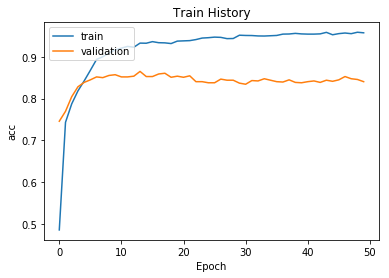

In [37]:
show_train_history(model_history,'acc','val_acc')

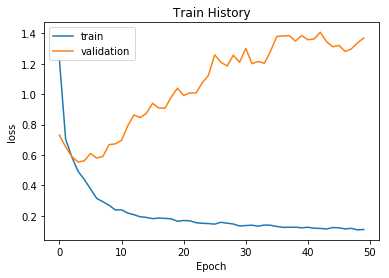

In [38]:
show_train_history(model_history,'loss','val_loss')

In [39]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

def predict_class(data):
    y_predict_probability = model.predict(data, batch_size=64, verbose=1)
    predict_arr = []
    predictClass = []
    for row in y_predict_probability: 
            classIndex=0
            selectClass=0
            selectProbability=0
            for item in row: 
                #print(float(item))
                if(selectProbability <= float(item)):
                    #print(classIndex)
                    selectProbability=float(item)
                    selectClass=classIndex
                classIndex=classIndex+1
            predictClass.append(selectClass)
            
    return to_cat_name(predictClass),predictClass,y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict_class(x_val)

2850/2850 [==============================] - 1s 294us/step


In [40]:
answer_name = to_cat_name(y_val)

In [41]:
#model.predict_classes(x_val)

In [42]:
x_val

array([[   0,    0,    0, ...,  299,   91,   14],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ..., 1795,   15,   60],
       ...,
       [   0,    0,    0, ..., 1333,  569,   38],
       [   0,    0,    0, ...,   10,   84,   19],
       [   0,    0,    0, ...,  120,  137,   19]], dtype=int32)

In [43]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [44]:
# model.predict(x_val)

In [45]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [46]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [47]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.24140350877192984 !!!!!!!!


In [48]:
differ_ans=predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]
differ_ans

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
6601,"訪客,透過,公司,網路,連回,訪客,公司",0,Outlook與郵件,3,網路,"[0.9030911, 0.0969089]"
6551,"北棟,2,樓,警衛室,顯示,網頁",1,SAP,3,網路,"[0.4608363, 0.5391637]"
8471,"類型,使用,proxy,172.20,168.133,port,80,進行,網路,連線,遇到...",0,Outlook與郵件,3,網路,"[0.85377836, 0.1462216]"
2765,"b,北棟,2f,網路,不通",0,Outlook與郵件,3,網路,"[0.5128045, 0.48719552]"
2361,"網路,芳鄰,到,ap,ip,10.242,232.204,完,密碼,重,開機,後",0,Outlook與郵件,3,網路,"[0.5340157, 0.46598434]"
9363,"ecn,no,e0,轉入,218",0,Outlook與郵件,1,SAP,"[0.86328435, 0.13671564]"
14087,"申請,會議室,無線網路",0,Outlook與郵件,3,網路,"[0.7926177, 0.20738234]"
146,"an,治具,server,原為,zohan,已轉,部門,而此,設備,需要,入,廣達,網域,能...",1,SAP,3,網路,"[0.37278575, 0.62721425]"
11975,"福委會,payeasy,合作,但常,接獲,反映,連線,payeasy,福委",1,SAP,3,網路,"[0.43364117, 0.5663588]"
1333,"回家,登入,sap,有時,okay,有時,fail",0,Outlook與郵件,3,網路,"[0.76566774, 0.23433223]"


In [49]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,656,336,174,1001,238
SAP,169,32,51,156,37


In [50]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)

In [51]:
pd.DataFrame(differ_ans).to_csv('CNN_v4.csv')

In [52]:
dfTest = pd.read_csv('data/19999_test_question.csv')#usecols=['description','category_a', 'category_a_target']

In [53]:
p

NameError: name 'p' is not defined

## dfTest

In [ ]:
def cut_to_word3(s):
    blCondition=True
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    combieNO=''
    beforeWord=''
    blAdd=True
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        conditionWord = str(combieNO) + str(w)
        
        if combieNO != '' and len(w)>1:# and len(conditionWord) == 4:
            combie = combie + w +','
            combie = combie+combieNO+w
            #print(combieNO+w)
        else:        
            #87.2%=>
            if w in ['修改','顯示','作業','申請單','問題','系統'] and beforeWord!='' and blCondition and len(w)>1:
                combie = combie +w+','
                combie = combie+beforeWord+w
            else:
                if w not in ['無法'] and len(w)>1:
                    combie = combie + w
                else:
                    blAdd=False
                 
        if i < len(w_list) - 1 and combie !='' and blAdd:
            combie = combie + ','
            
        blAdd = True
        if w in ['無法','不能','加班','請假','預約'] and blCondition:#,'安裝','編輯','刪除','新增','作業','忘記','系統','發生','作業','下載','上傳','開啟','安裝']
            combieNO = w
        else:
            combieNO = ''
        beforeWord=w
    return combie    

dfTest['cut_words'] = dfTest['description_clean'].apply(lambda s: cut_to_word3(s.strip()))

In [ ]:
dfTest

In [ ]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(dfTest.cut_words)

x_test_new = preprocessing(dfTest.cut_words, max_len=MAX_LEN)
char_index = token_intent.word_index

In [ ]:
mapping

In [ ]:
y_test_new=dfTest.category_target

In [ ]:
from data_utils import *

In [ ]:
y_predict_name_new, y_predict_new, predict_arr_new,y_predict_probability_new = predict_class(model,x_test_new,64,mapping)

In [ ]:
predict_df = pd.DataFrame({'1_sentence':dfTest.description_clean,'2_sentence':dfTest.cut_words,
              '3_y_predict':y_predict_new,
              '4_y_predict_name':y_predict_name_new,
              '5_answer':y_test_new,
              '6_answer':mapping[y_test_new],
              '7_y_predict_probability':list(predict_arr_new),
              })
#print( format(y_predict_probability, '.3%'))
predict_df[:14]